#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor   
from catboost import CatBoostRegressor  
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# общий путь
try:
    data = pd.read_csv('/datasets/taxi.csv')
# локальный путь    
except:
    data = pd.read_csv('D:/Git/YandexPracticum/Time_series/taxi.csv')

In [3]:
data.shape

(26496, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
data.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div style="border:solid gray 2px; padding: 20px">
    Пропуски, нулевые значения и дубликаты в датасете отсутствуют. Первым признаком является дата с временным интервалом 10 минут, второй признак - количество заказов в этот интервал.</div>

Установим индекс таблицы равным столбцу datetime

In [10]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])   
except:
    data = pd.read_csv('D:/Git/YandexPracticum/Time_series/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
print(data.index.is_monotonic)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [11]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<div style="border:solid gray 2px; padding: 20px">
Хронологический порядок расположения даты и времени соблюден, временной ряд не имеет разрывов
</div>    

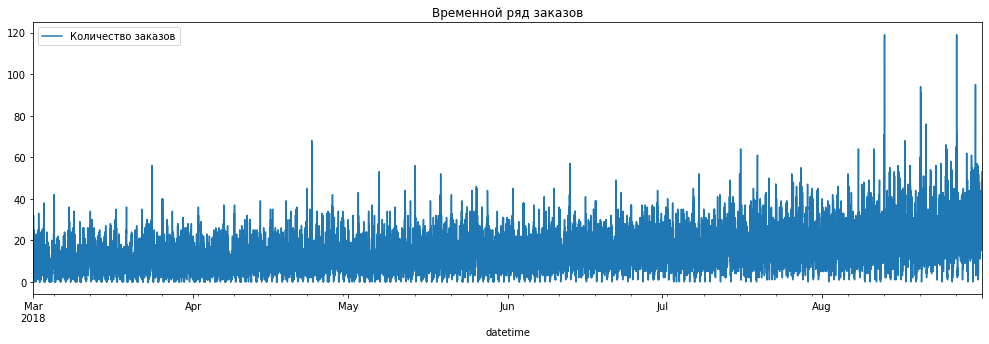

In [12]:
data.plot(figsize=(17,5))
plt.title('Временной ряд заказов');
plt.legend(['Количество заказов'], loc = 2)
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    Данные представлены с начала марта 2018 года по конец августа 2018 года.</div>

Изменим интервал временного ряда на 1 час, значения за этот период просуммируем

In [13]:
data = data.resample('1H').sum()
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [14]:
data.shape

(4416, 1)

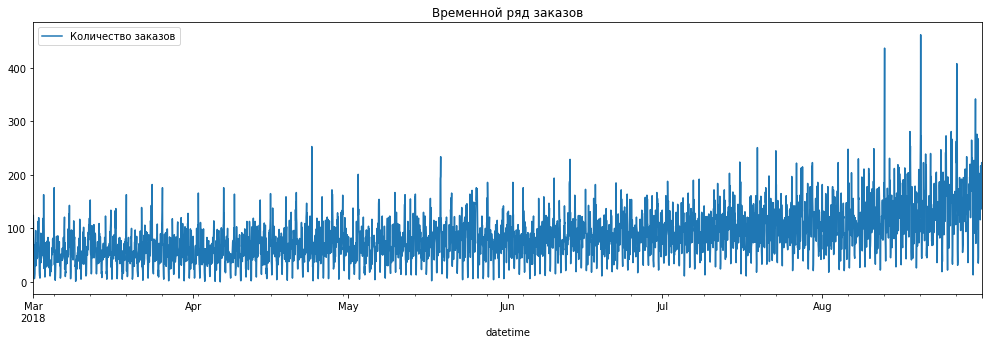

In [15]:
data.plot(figsize=(17,5))
plt.title('Временной ряд заказов');
plt.legend(['Количество заказов'], loc = 2)
plt.show();

## Анализ

Разложим временной ряд на тренд и сезонную компоненту

In [16]:
decomposed = seasonal_decompose(data)

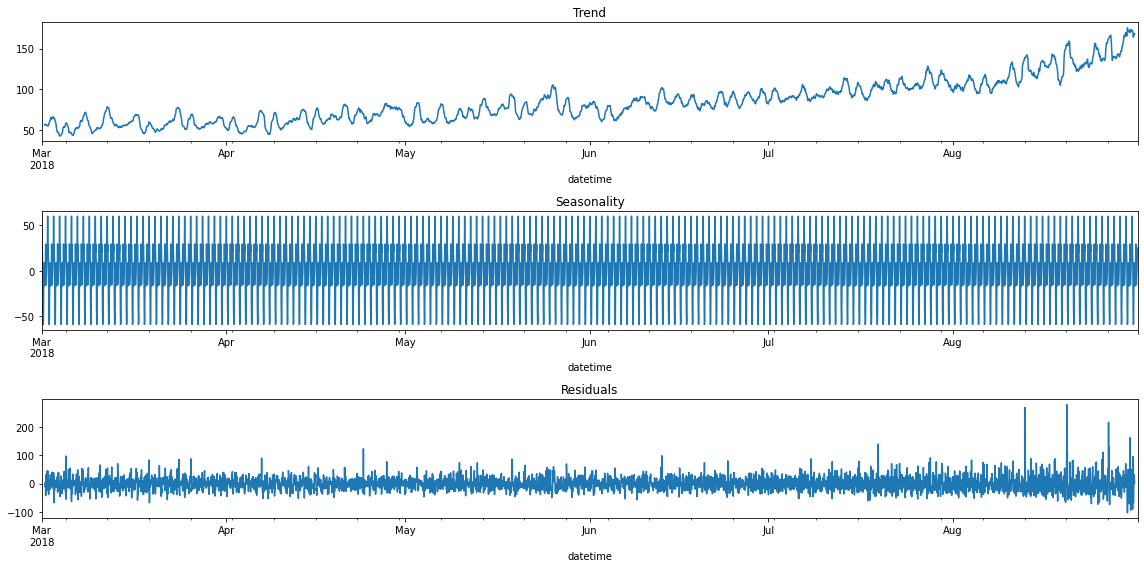

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div style="border:solid gray 2px; padding: 20px">
    Общий тренд периода положительный, наблюдается частая сезонность.</div>

Посмотрим на сезонность за месяц, неделю и день

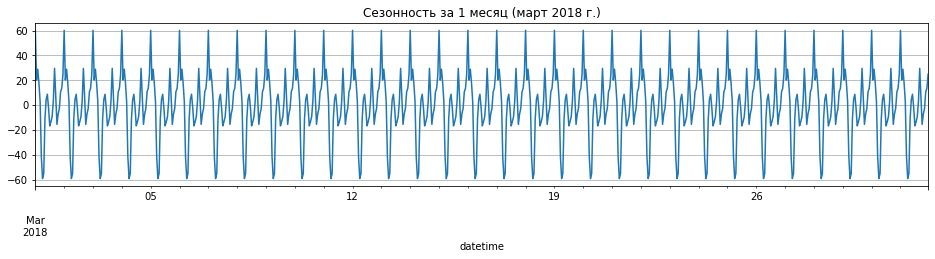

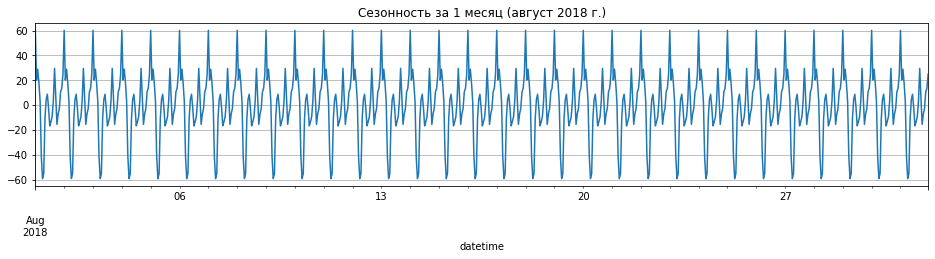

In [18]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-31 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 месяц (март 2018 г.)')
plt.show();

decomposed.seasonal['2018-08-01 00:00:00':'2018-08-31 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 месяц (август 2018 г.)')
plt.show();

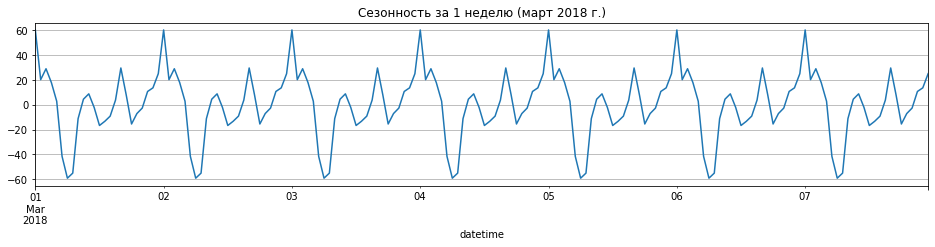

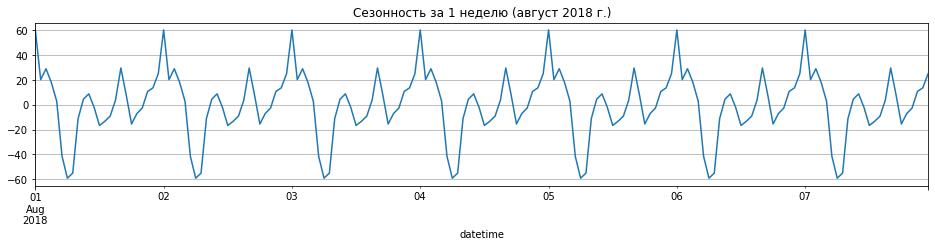

In [19]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-07 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 неделю (март 2018 г.)')
plt.show();

decomposed.seasonal['2018-08-01 00:00:00':'2018-08-07 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 неделю (август 2018 г.)')
plt.show();

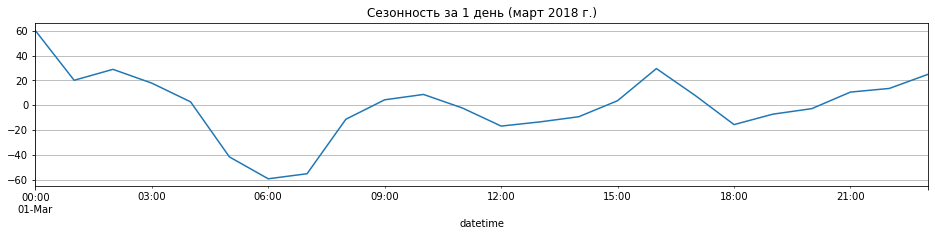

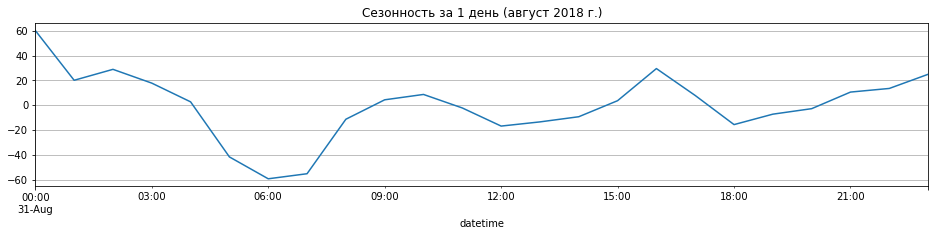

In [20]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 день (март 2018 г.)')
plt.show();

decomposed.seasonal['2018-08-31 00:00:00':'2018-08-31 23:00:00'].plot(figsize=(16, 3), grid=True) 
plt.title('Сезонность за 1 день (август 2018 г.)')
plt.show();

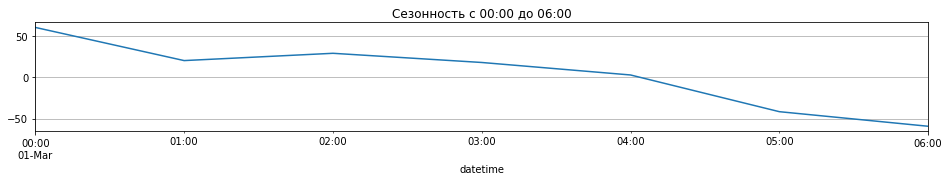

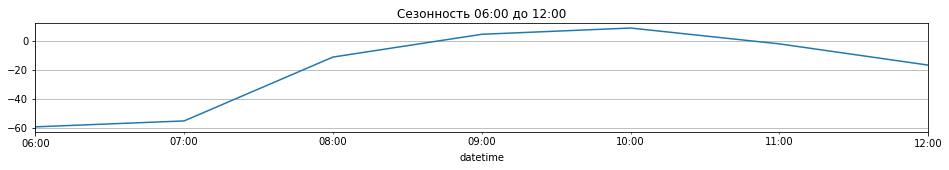

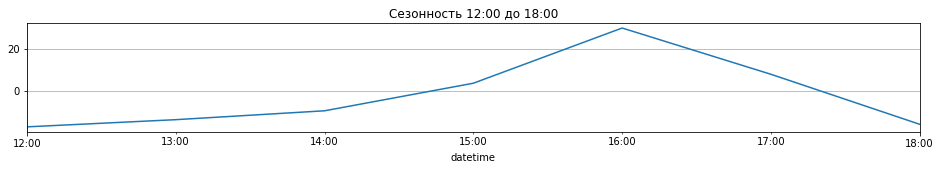

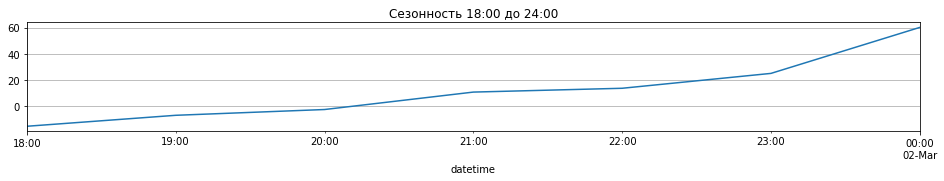

In [21]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 06:00:00'].plot(figsize=(16, 2), grid=True) 
plt.title('Сезонность с 00:00 до 06:00')
plt.show();

decomposed.seasonal['2018-03-01 06:00:00':'2018-03-01 12:00:00'].plot(figsize=(16, 2), grid=True) 
plt.title('Сезонность 06:00 до 12:00')
plt.show();

decomposed.seasonal['2018-03-01 12:00:00':'2018-03-01 18:00:00'].plot(figsize=(16, 2), grid=True) 
plt.title('Сезонность 12:00 до 18:00')
plt.show();

decomposed.seasonal['2018-03-01 18:00:00':'2018-03-02 00:00:00'].plot(figsize=(16, 2), grid=True) 
plt.title('Сезонность 18:00 до 24:00')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    На графиках заметна ежедневная сезонность, что скорее всего связано со стабильным расписанием аэропортов. В течении дня выражены 3 основных пика с максимальным количеством заказов: полночь, утро с 9 до 10, днем с 15 до 16</div>

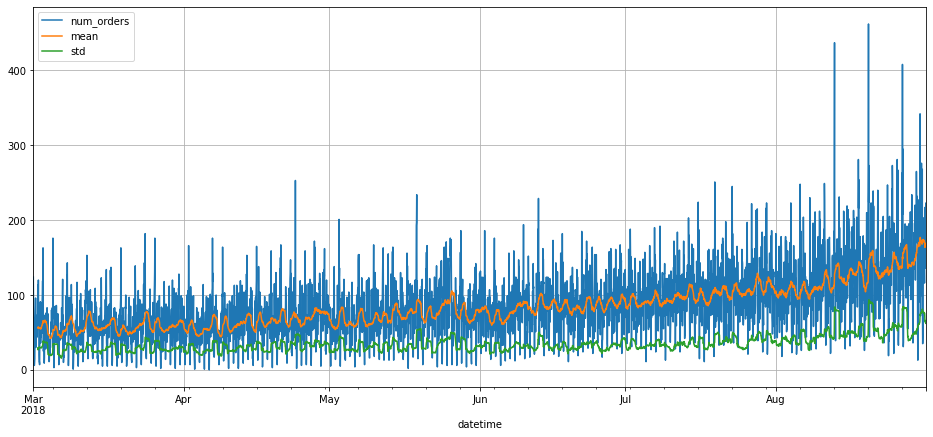

In [22]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()   # скользящее стандартное отклонение
data.plot(figsize=(16, 7), grid=True) 
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    Временной ряд нестационарный, необходимо сделать его стационарным.</div>

In [23]:
data = data.drop(['mean', 'std'], axis=1)

In [24]:
df = data

## Обучение

Создаем набор признаков для обучения моделей

In [25]:
def make_features(df, max_lag, rolling_mean_size):
    
    # создание календарных признаков
    #df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    #df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    # создание отстающих значений
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # разделение данных на выборки
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    # создание признаков для модели
    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']

    features_test = test.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
      
    return features_train, target_train, features_test, target_test

features_train, target_train, features_test, target_test = make_features(df, 1, 24)

In [26]:
features_train.head(3)

,dayofweek,hour,lag_1,rolling_mean
datetime,,,,
2018-03-02 00:00:00,4,0,58.0,56.833333
2018-03-02 01:00:00,4,1,90.0,55.416667
2018-03-02 02:00:00,4,2,120.0,56.875000


In [27]:
tscv = TimeSeriesSplit(n_splits=8)

### Linear Regression

In [28]:
%%time

model_linReg = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', cross_val_score(model_linReg, 
                         features_train, 
                         target_train, 
                         cv = tscv, 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean())

Значение метрики RMSE на обучающей выборке для LinearRegression -31.366763577025026
CPU times: total: 93.8 ms
Wall time: 8.74 s


In [29]:
index_table = 0
table = pd.DataFrame(columns=['Модель','RMSE'])
index_table +=1
table.loc[index_table] = ['Linear Regression', 31.36676]
table

,Модель,RMSE
1,Linear Regression,31.36676


### CatBoostRegressor

In [30]:
%%time

grid = {'verbose' : [False],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 10]
       }

model_cat = CatBoostRegressor(iterations=50, random_state=12345)

grid_cv_cat = GridSearchCV(model_cat, param_grid=grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
grid_cv_cat.fit(features_train, target_train)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
CPU times: total: 2.44 s
Wall time: 11.5 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000018E103D2880>,
             n_jobs=-1,
             param_grid={'depth': [4, 10], 'learning_rate': [0.03, 0.1],
                         'verbose': [False]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
grid_cv_cat.best_score_

-25.202316655160068

In [32]:
index_table +=1
table.loc[index_table] = ['CatBoostRegressor', 25.20231]
table

,Модель,RMSE
1,Linear Regression,31.36676
2,CatBoostRegressor,25.20231


### LightLGB

In [33]:
%%time

param_grid = {'max_depth':[2,10], 'learning_rate': [0.1, 0.8]}

lgb_estimator = lgb.LGBMRegressor()

gsearch_lgboost = GridSearchCV(lgb_estimator, 
                               param_grid = param_grid, 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1, 
                               cv=tscv, 
                               verbose=1)
gsearch_lgboost.fit(features_train, target_train)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
CPU times: total: 594 ms
Wall time: 2.12 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.8], 'max_depth': [2, 10]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [34]:
gsearch_lgboost.best_score_

-24.696163693231526

In [35]:
index_table +=1
table.loc[index_table] = ['LGBMRegressor', 24.69616]
table

,Модель,RMSE
1,Linear Regression,31.36676
2,CatBoostRegressor,25.20231
3,LGBMRegressor,24.69616


### RandomForestRegressor

In [36]:
%%time

model_RandForest = RandomForestRegressor(random_state = 12345)

# параметры для GridSearch
parametrs_grid = {'n_estimators': range(10, 100, 20),'max_depth' : range(10, 100, 20)}
grid_cv = GridSearchCV(model_RandForest, 
                       param_grid=parametrs_grid, 
                       scoring='neg_root_mean_squared_error', 
                       n_jobs=-1, 
                       cv=tscv, 
                       verbose=1)
grid_cv.fit(features_train, target_train)

Fitting 8 folds for each of 25 candidates, totalling 200 fits
CPU times: total: 2.39 s
Wall time: 40.2 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(10, 100, 20),
                         'n_estimators': range(10, 100, 20)},
             scoring='neg_root_mean_squared_error', verbose=1)

In [37]:
grid_cv.best_score_

-24.80199685241009

In [38]:
index_table +=1
table.loc[index_table] = ['RandomForestRegressor', 24.80199]
table

,Модель,RMSE
1,Linear Regression,31.36676
2,CatBoostRegressor,25.20231
3,LGBMRegressor,24.69616
4,RandomForestRegressor,24.80199


<div style="border:solid gray 2px; padding: 20px">
    Все модели показали результат метрики RMSE ниже 48</div>

## Тестирование

In [39]:
%%time

predict_model_lgb = gsearch_lgboost.predict(features_test)
rmse_model_lgb = mse(target_test, predict_model_lgb)**(0.5)
print('RMSE LGBMRegressor =', rmse_model_lgb)

RMSE LGBMRegressor = 43.506108154224414
CPU times: total: 15.6 ms
Wall time: 16 ms


In [40]:
index_table_test = 0
table_test = pd.DataFrame(columns=['Модель','RMSE'])
index_table_test +=1
table_test.loc[index_table_test] = ['LGBMRegressor', rmse_model_lgb]
table_test

,Модель,RMSE
1,LGBMRegressor,43.506108


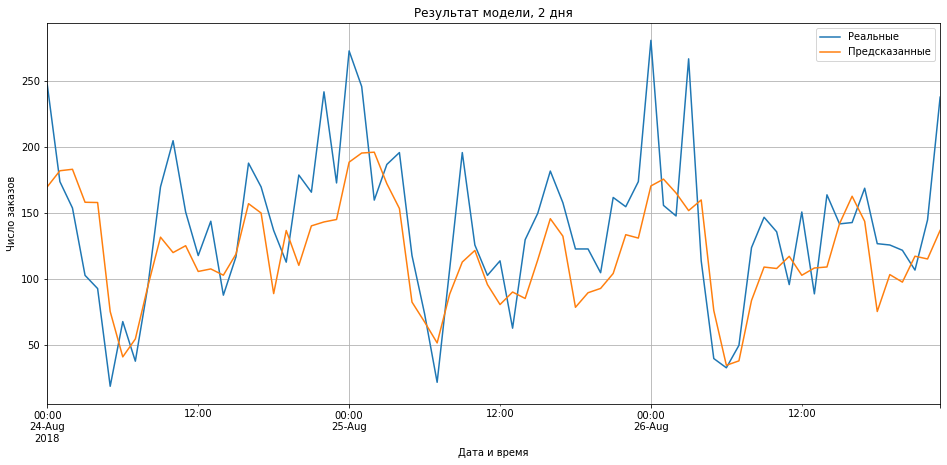

In [41]:
data_t = pd.DataFrame(target_test, index = target_test.index)
data_t.rename(columns={'num_orders':'Реальные'}, inplace=True)
data_t['Предсказанные'] = pd.DataFrame(predict_model_lgb, index = target_test.index) 
data_t.loc['2018-08-24 00:00:00':'2018-08-26 23:00:00', ['Реальные', 'Предсказанные']].plot(figsize=(16, 7), grid=True) 
plt.title('Результат модели, 2 дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.show();

<div style="border:solid gray 2px; padding: 20px">
    <b>Вывод:</b> Лучший результат показала модель LGBMRegressor, значение метрики качества RMSE на тестовой выборке 43.5, что удовлетворяет требованию проекта.</div>

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid gray 2px; padding: 20px">
<b>Общий вывод:</b> В ходе проекта были заагружены данные, проверены на наличие пропусков, нулевых значений, дубликатов. Данные были исследованы, изменен интервал и просумированы значения нового интервала. Проведено исследование тренда и сезонности временного ряда. Созданы дополнительные календарные признаки. В ходе проведено обучение нескольких моделей с различными гиперпараметрами, определены параметры для смещения и скользящего окна, достаточные для получения требуемого качества метрики моделей. Лучшая модель проверена на тестовой выборке и показала требуемое качество предсказания.</div>
